In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# VIX prediction
- Unsupervised learning to label VIX returns
- Supervised learning to predict the labels

In [2]:
monthly = pd.read_excel('macro_data.xlsx',sheet_name = 0)
daily = pd.read_excel('macro_data.xlsx',sheet_name = 1)

In [3]:
def clean(monthly):
    
    data = monthly.loc[6:, monthly.columns[1::3]]
    col = monthly.iloc[2,::3].tolist()
    date = pd.to_datetime(monthly.iloc[6:,0])
    data.columns = col
    data.index = date
    data.index.name = 'Date'
    
    return data

In [4]:
dataM = clean(monthly)
dataD = clean(daily)

dataM = dataM.merge(dataD[['VIX']], left_index = True, right_index = True).drop(columns = ['EuroDebtToGDP'])

dataM['VIX1mret'] = dataM['VIX'].shift(-1)/dataM['VIX']-1
dataM['VIX1mret_lagged'] = dataM['VIX']/dataM['VIX'].shift(1)-1
dataM['PrivateHouseStartedGrowth'] = dataM['PrivateHouseStarted']/dataM['PrivateHouseStarted'].shift(1) - 1
dataM['PrivateDebtOutstandingGrowth'] = dataM['PrivateDebtOutstandingTotal']/dataM['PrivateDebtOutstandingTotal'].shift(3) - 1
dataM['PrivateBorrowTotalGrowth'] = dataM['PrivateBorrowTotal']/dataM['PrivateBorrowTotal'].shift(3) - 1

dataM = dataM.drop(columns = ['PrivateDebtOutstandingTotal','PrivateBorrowTotal','PrivateHouseStarted'])

dataD['VIX1dret'] = dataD['VIX'].shift(-1)/dataD['VIX']-1
dataD['VIX1dret_lagged'] = dataD['VIX']/dataD['VIX'].shift(1)-1
#dataD['VIX1dret'].map(float).hist(bins=20)

In [13]:
dataM.head()

,GDPQ,ConsumptionQ,GovtSpendingQ,InvestmentQ,CPI_Y,FedDebtToGDP,Unemployment,PPI_Y,CPI_Urban_M,ConsumptionM,PrivateDebtGrowth,SurplusToGDP,VIX,VIX1mret,VIX1mret_lagged,PrivateHouseStartedGrowth,PrivateDebtOutstandingGrowth,PrivateBorrowTotalGrowth
Date,,,,,,,,,,,,,,,,,,
1990-03-30,4.4,3.4,6.6,4,5.23,51.969,5.3,4.5,0.5,0.7,7.8,-3,19.73,-0.0106437,NaN,NaN,NaN,NaN
1990-04-30,4.4,3.4,6.6,4,5.23,52.747,5.3,3.7,0.2,0.4,7.8,-2.9,19.52,-0.110143,-0.0106437,-0.0318076,NaN,NaN
1990-05-31,4.4,3.4,6.6,4,5.23,52.747,5.3,3.1,0.2,0.2,7.8,-3.2,17.37,-0.107657,-0.110143,-0.0288462,NaN,NaN
1990-06-29,1.5,1.2,0.6,0.1,4.6,52.747,5.33,3.1,0.6,0.8,6.4,-3.5,15.5,0.361935,-0.107657,-0.0288779,0.0157609,-0.16746
1990-07-31,1.5,1.2,0.6,0.1,4.6,53.753,5.33,3.6,0.5,0.5,6.4,-3.6,21.11,0.41639,0.361935,-0.00509771,0.0157609,-0.16746


## Kmeans Clustering of VIX returns 
- unsupervised

### Self defined model class

In [8]:
from sklearn.cluster import KMeans 

class kmeans_1d:
    
    def __init__(self, x, n = 5):
        self.x = x
        self.date = x.index
        self.n_clusters = n
        self.kmeans = self.fit()
        self.label = self.mapping()
    
    def fit(self):
        date = self.date
        if self.x.ndim == 1:
            self.x = np.array(self.x).reshape(-1,1)
        kmeans = KMeans(n_clusters = self.n_clusters).fit(self.x)
        return kmeans
    
    def mapping(self):
        kmeans = self.kmeans

        # map raw_label to sorted label
        label = pd.DataFrame({'center':kmeans.cluster_centers_[:,0],
                      'raw_label':kmeans.predict(kmeans.cluster_centers_[:,0].reshape(-1,1))})
        label = label.sort_values(by ='center')
        label['label'] = range(1,self.n_clusters+1)
        
        return label
    
    def predict(self, to_predict):
        kmeans = self.kmeans
        label = self.label
        
        def label_transform(l):
            return label[label.raw_label==l]['label'].iloc[0]
        
        return label_transform(kmeans.predict(to_predict)[0])
    
    def train(self):
        # turn VIX return into VIX label in train set
        
        # map return to raw_label
        a = pd.DataFrame({'raw_label':self.kmeans.labels_,
                      '1dret': self.x[:,0]})
        
        return a.merge(self.label,on = 'raw_label',how = 'left').set_index(self.date).drop(columns = 'raw_label')

### Fit kmeans for train set

In [43]:
split = 12*20
n_clusters = 4

y = dataM[3:split]['VIX1mret']
y = kmeans_1d(y, n_clusters).train()['label']
X = dataM[3:split].drop(columns = 'VIX1mret')

In [15]:
X.head()

,GDPQ,ConsumptionQ,GovtSpendingQ,InvestmentQ,CPI_Y,FedDebtToGDP,Unemployment,PPI_Y,CPI_Urban_M,ConsumptionM,PrivateDebtGrowth,SurplusToGDP,VIX,VIX1mret_lagged,PrivateHouseStartedGrowth,PrivateDebtOutstandingGrowth,PrivateBorrowTotalGrowth
Date,,,,,,,,,,,,,,,,,
1990-06-29,1.5,1.2,0.6,0.1,4.6,52.747,5.33,3.1,0.6,0.8,6.4,-3.5,15.5,-0.107657,-0.0288779,0.0157609,-0.16746
1990-07-31,1.5,1.2,0.6,0.1,4.6,53.753,5.33,3.6,0.5,0.5,6.4,-3.6,21.11,0.361935,-0.00509771,0.0157609,-0.16746
1990-08-31,1.5,1.2,0.6,0.1,4.6,53.753,5.33,5.2,0.8,0.7,6.4,-4.1,29.9,0.41639,-0.0478224,0.0157609,-0.16746
1990-09-28,0.3,1.6,0.6,-7.5,5.53,53.753,5.7,6,0.7,0.6,5.7,-3.7,29.11,-0.0264214,-0.0044843,0.0143151,-0.0844451
1990-10-31,0.3,1.6,0.6,-7.5,5.53,56.036,5.7,6.4,0.7,0,5.7,-3.8,30.04,0.0319478,-0.0864865,0.0143151,-0.0844451


In [17]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

reg = LinearRegression()
reg.fit(X,y)
reg.score(X,y)
# reg.fit(pca.transform(X_),y)
# plt.plot(reg.predict(pca.transform(X_)))

# reg.coef_

0.06107358271925444

In [612]:
np.corrcoef(reg.predict(pca.transform(X_)),y.astype(float))

array([[1.        , 0.25328672],
       [0.25328672, 1.        ]])

In [44]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X, y)
clf.score(X,y)

0.48945147679324896

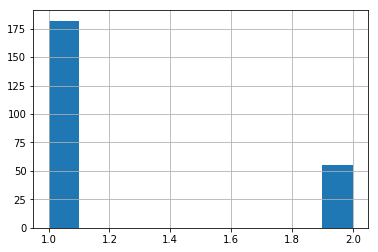

In [548]:
y['label'].hist()

## PCA for the X matrix

In [34]:
from sklearn.decomposition import PCA

X_ = (X - X.mean())/X.std()

pca = PCA(n_components = 5)
pca.fit(X_)
pca.explained_variance_ratio_

array([0.21957988, 0.15448214, 0.11383643, 0.10215583, 0.07577652])

GDPQ                           -6.736290e-16
ConsumptionQ                    8.788094e-16
GovtSpendingQ                  -2.412510e-16
InvestmentQ                    -3.260402e-16
CPI_Y                           2.896886e-15
FedDebtToGDP                    2.428437e-15
Unemployment                   -1.637696e-15
PPI_Y                          -2.145494e-16
CPI_Urban_M                    -2.004960e-16
ConsumptionM                   -6.169467e-16
PrivateDebtGrowth              -2.061174e-16
SurplusToGDP                   -1.892532e-16
VIX                            -2.433005e-16
VIX1mret_lagged                 8.432074e-18
PrivateHouseStartedGrowth      -1.440479e-17
PrivateDebtOutstandingGrowth    1.832571e-15
PrivateBorrowTotalGrowth       -5.059244e-17
dtype: float64

In [592]:
components = pd.Series(pca.components_[0],index = X.columns)
components.sort_values(ascending = False)

VIX                             0.240935
GovtSpendingQ                   0.054733
CPI_Y                           0.009992
SurplusToGDP                    0.003333
PrivateBorrowTotalGrowth        0.002473
VIX1mret_lagged                 0.000565
PrivateDebtOutstandingGrowth   -0.000019
PrivateHouseStartedGrowth      -0.000245
CPI_Urban_M                    -0.000574
PPI_Y                          -0.001518
PrivateDebtGrowth              -0.004586
ConsumptionM                   -0.007091
Unemployment                   -0.007372
FedDebtToGDP                   -0.056610
ConsumptionQ                   -0.058713
GDPQ                           -0.160358
InvestmentQ                    -0.952020
dtype: float64

In [533]:
pd.DataFrame(pca.transform(X))

,0,1,2,3,4
0,1.277108,-8.722420,-5.227323,3.251228,-1.135571
1,3.024986,-3.575045,-6.601078,3.854206,-0.835118
2,5.647839,3.821226,-10.012576,5.426099,-0.096272
3,12.649392,0.641485,-9.399957,5.728474,0.046826
4,13.065399,2.279682,-7.872259,5.830522,0.637722
5,10.676244,-4.492301,-4.734570,5.636091,1.261692
6,25.245058,-4.428707,-5.132692,6.798436,1.662685
7,23.719160,-8.431346,-1.680089,5.384070,0.976093
8,23.819526,-8.120538,-1.796035,5.038743,0.578416
9,14.748168,-9.335769,-0.513697,3.744142,-0.110541


In [475]:
dataM['PrivateBorrowTotal']

Date
1990-03-30     819.3
1990-04-30     819.3
1990-05-31     819.3
1990-06-29     682.1
1990-07-31     682.1
1990-08-31     682.1
1990-09-28     624.5
1990-10-31     624.5
1990-11-30     624.5
1990-12-31     629.7
1991-01-31     629.7
1991-02-28     629.7
1991-03-29     440.5
1991-04-30     440.5
1991-05-31     440.5
1991-06-28       574
1991-07-31       574
1991-08-30       574
1991-09-30     504.5
1991-10-31     504.5
1991-11-29     504.5
1991-12-31     608.6
1992-01-31     608.6
1992-02-28     608.6
1992-03-31     561.4
1992-04-30     561.4
1992-05-29     561.4
1992-06-30     505.6
1992-07-31     505.6
1992-08-31     505.6
               ...  
2016-05-31    2670.7
2016-06-30    2082.6
2016-07-29    2082.6
2016-08-31    2082.6
2016-09-30    2429.1
2016-10-31    2429.1
2016-11-30    2429.1
2016-12-30    1151.6
2017-01-31    1151.6
2017-02-28    1151.6
2017-03-31     986.7
2017-04-28     986.7
2017-05-31     986.7
2017-06-30    2034.7
2017-07-31    2034.7
2017-08-31    2034.7
2017-09-